In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn import metrics as skm
from fairlearn.reductions import GridSearch, DemographicParity, ErrorRate
from fairlearn.metrics import MetricFrame, selection_rate, count

In [2]:
random_seed = 42
num_applicants = 1000
rng = np.random.default_rng(seed=random_seed)

In [3]:
# Set up simulated dataset for historical data on PV installer hirings
data_df = pd.DataFrame(columns={'is_male', 'years_carpenter', 'years_security_guard',  'years_waiter', 'hired'})
data_df['is_male'] = rng.choice([True, False], num_applicants)
data_df['years_carpenter'] = rng.exponential(1.0, num_applicants)
num_men = data_df['is_male'].sum()
num_women = num_applicants - num_men

# We will posit that women are more likely to have experience as waiters, while men are more likely
# to have experience as security guards.
data_df.loc[ data_df['is_male'], 'years_security_guard'] = rng.exponential(2  , num_men)
data_df.loc[~data_df['is_male'], 'years_security_guard'] = rng.exponential(0.5, num_women)
data_df.loc[ data_df['is_male'], 'years_waiter'        ] = rng.exponential(0.5, num_men)
data_df.loc[~data_df['is_male'], 'years_waiter'        ] = rng.exponential(2, num_women)

# Candidates are historically more likely to be hired if they relevant experience (carpentry) and if they are men (bias).
candidate_scores = rng.normal(size=num_applicants) + 0.4*data_df['is_male'] + 0.4*data_df['years_carpenter']
data_df['hired'] = candidate_scores > 0.4

data_df = data_df.astype(float)

In [4]:
# Show differences in these variables between men and women.
print('Num men hired: ', (data_df['hired'].astype(bool) & data_df['is_male'].astype(bool)).sum())
print('Num women hired: ',  (data_df['hired'].astype(bool) & ~data_df['is_male'].astype(bool)).sum())
data_df.groupby('is_male').mean()

Num men hired:  316
Num women hired:  243


,hired,years_carpenter,years_waiter,years_security_guard
is_male,,,,
0.0,0.477407,1.039427,1.961479,0.503129
1.0,0.643585,0.999032,0.496896,2.058174


In [5]:
# Set up the training and test data
X = data_df.drop(columns=['hired', 'is_male'])
y = data_df['hired']
s = data_df['is_male'].astype(float) # Sensitive features

X_train, X_test, y_train, y_test, s_train, s_test = train_test_split(
            X,
            y,
            s,
            test_size=0.2,
            random_state=random_seed,
        )

In [6]:
# Fit a model without bias mitigation
unmitigated_model = LogisticRegression()
unmitigated_model.fit(X_train,y_train)

LogisticRegression()

In [7]:
print("weights:")
pd.DataFrame(unmitigated_model.coef_, columns=X_train.columns)

weights:


,years_carpenter,years_waiter,years_security_guard
0,0.739434,-0.057969,0.067939


In [8]:
# Print the accuracy of the model without bias mitigation
# and the difference in selection rate between men and women
# using this model.
m =  MetricFrame(metrics={"accuracy": skm.accuracy_score,
                            "selection_rate": selection_rate,
                            "count": count},
                            sensitive_features=s_test,
                            y_true=y_test,
                            y_pred=unmitigated_model.predict(X_test))
print("accuracy: ", m.overall['accuracy'])
print("selection rate diff: ")
print(m.by_group['selection_rate'])

accuracy:  0.63
selection rate diff: 
is_male
0.0    0.472727
1.0    0.644444
Name: selection_rate, dtype: object


In [9]:
# Find a model that mitigates bias
# From https://fairlearn.org/v0.7.0/auto_examples/plot_grid_search_census.html#sphx-glr-auto-examples-plot-grid-search-census-py
sweep = GridSearch(LogisticRegression(penalty='l1', C=0.9, 
              solver='liblinear', max_iter=20000, class_weight='balanced'), DemographicParity(), grid_size=71)
sweep.fit(X_train, y_train, sensitive_features=s_train)
predictors = sweep.predictors_

/opt/homebrew/Caskroom/miniforge/base/envs/temp-env/lib/python3.8/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/opt/homebrew/Caskroom/miniforge/base/envs/temp-env/lib/python3.8/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  lambda_event = (lambda_vec["+"] - self.ratio * lambda_vec["-"]).sum(level=_EVENT) / \
/opt/homebrew/Caskroom/miniforge/base/envs/temp-env/lib/python3.8/site-packages/fairlearn/reductions/_moments/utility_parity.py:251: FutureWarning

In [10]:
errors, disparities = [], []
for m in predictors:
    def classifier(X): return m.predict(X)

    error = ErrorRate()
    error.load_data(X_train, pd.Series(y_train), sensitive_features=s_train)
    disparity = DemographicParity()
    disparity.load_data(X_train, pd.Series(y_train), sensitive_features=s_train)

    errors.append(error.gamma(classifier)[0])
    disparities.append(disparity.gamma(classifier).max())

all_results = pd.DataFrame({"predictor": predictors, "error": errors, "disparity": disparities})

non_dominated = []
for row in all_results.itertuples():
    errors_for_lower_or_eq_disparity = all_results["error"][all_results["disparity"] <= row.disparity]
    if row.error <= errors_for_lower_or_eq_disparity.min():
        non_dominated.append(row.predictor)

Text(0, 0.5, 'selection rate difference')

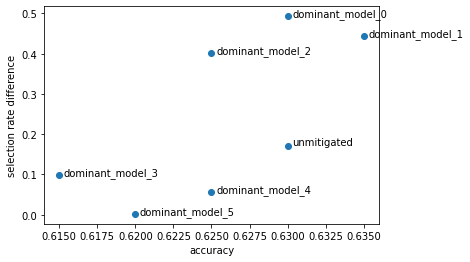

In [11]:
predictions = {"unmitigated": unmitigated_model.predict(X_test)}
metric_frames = {"unmitigated": MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                              "selection_rate": selection_rate,
                                              "count": count},
                                     sensitive_features=s_test,
                                     y_true=y_test,
                                     y_pred=predictions["unmitigated"])}
for i in range(len(non_dominated)):
    key = "dominant_model_{0}".format(i)
    predictions[key] = non_dominated[i].predict(X_test)

    metric_frames[key] = MetricFrame(metrics={"accuracy": skm.accuracy_score,
                                              "selection_rate": selection_rate,
                                              "count": count},
                                     sensitive_features=s_test,
                                     y_true=y_test,
                                     y_pred=predictions[key])

import matplotlib.pyplot as plt
x = [metric_frame.overall['accuracy'] for metric_frame in metric_frames.values()]
y = [metric_frame.difference()['selection_rate'] for metric_frame in metric_frames.values()]
keys = list(metric_frames.keys())
plt.scatter(x, y)
for i in range(len(x)):
    plt.annotate(keys[i], (x[i] + 0.0003, y[i]))
plt.xlabel("accuracy")
plt.ylabel("selection rate difference")


In [12]:
# Choose dominant_model_5 as the model to use
# because it has almost no bias and preserves
# accuracy
chosen_model = non_dominated[5]
print("Model weights:")
pd.DataFrame(chosen_model.coef_, columns=X_train.columns)

Model weights:


,years_carpenter,years_waiter,years_security_guard
0,0.728319,0.021342,-0.000614


In [13]:
m =  MetricFrame(metrics={"accuracy": skm.accuracy_score,
                            "selection_rate": selection_rate,
                            "count": count},
                            sensitive_features=s_test,
                            y_true=y_test,
                            y_pred=chosen_model.predict(X_test))
print("accuracy: ", m.overall['accuracy'])
print("selection rate diff: ")
print(m.by_group['selection_rate'])

accuracy:  0.62
selection rate diff: 
is_male
0.0    0.409091
1.0    0.411111
Name: selection_rate, dtype: object
